In [143]:
%matplotlib inline
import matplotlib.pyplot as plt
import json
from gensim.models import KeyedVectors
import pandas as pd
from collections import Counter
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [3]:
def eval_head_strict_at10(region2ref,refdf,glove_heads):
    acc_at_n = {1:0,5:0,10:0}
    total = 0

    for r in region2ref:
    #print r
        utt_mat = region2ref[r]
        this_df = refdf[refdf.region_id == int(r)]
        if len(this_df) > 0:
            gold_names = this_df.iloc[0]['names']
            total += 1
            
            for utt_pos in sorted(utt_mat.keys()):
            
                cand = [w for w,_ in utt_mat[utt_pos]]
                if cand[-1] in glove_heads:
                    for ix in acc_at_n:
                        if len(set(cand[-ix:]) & set(gold_names)) > 0:
                            acc_at_n[ix] += 1
                    break
                    
        else:
            break
    return acc_at_n,total

def eval_all_strict_at10(region2ref,refdf,glove_heads):
    acc_at_n = {1:0,5:0,10:0}
    total = 0

    for r in region2ref:
    #print r
        utt_mat = region2ref[r]
        this_df = refdf[refdf.region_id == int(r)]
        if len(this_df) > 0:
            gold_names = this_df.iloc[0]['names']
            total += 1
            
            hit_at_n = {1:False,5:False,10:False}
            for utt_pos in sorted(utt_mat.keys()):
            
                cand = [w for w,_ in utt_mat[utt_pos]]
                for ix in hit_at_n:
                    if len(set(cand[-ix:]) & set(gold_names)) > 0:
                        hit_at_n[ix] = True
            for ix in hit_at_n:
                acc_at_n[ix] += int(hit_at_n[ix])
        else:
            break
    return acc_at_n,total

def eval_head_loose(region2ref,refdf,glove_heads):
    acc_at_1 = 0
    total = 0

    for r in region2ref:
    #print r
        utt_mat = region2ref[r]
        this_df = refdf[refdf.region_id == int(r)]
        if len(this_df) > 0:
            gold_names = this_df.iloc[0]['names']
            total += 1
            
            head_found = False
            for utt_pos in sorted(utt_mat.keys()):
            
                cand = [w for w,_ in utt_mat[utt_pos]]
                if cand[-1] in glove_heads:
                    head_found = True
                    if cand[-1] in gold_names:
                        acc_at_1 += 1
                    
                    break
                    
            if not head_found:
                acc_at_1 += 1
                    
        else:
            break
    return acc_at_1,total
    

In [4]:
datap = "/media/compute/vol/dsg/sinaza/zero_shot_reg/data/"
glove_vocab = KeyedVectors.load_word2vec_format(datap+"glove.6B.300d.vocab.w2v.bin")
glove_heads = KeyedVectors.load_word2vec_format(datap+"glove.6B.300d.heads.w2v.bin")

In [5]:
refdf_path = datap+"refcoco_refdf_heads.json.gz"
refdf = pd.read_json(refdf_path,compression='gzip', orient='split')

In [6]:
refdf.head()

,i_corpus,image_id,region_id,names,refexps,cat,ix_Xfile
0,1,581857,1719310,"[person, lady, shirt]","[the lady with the blue shirt, lady with back ...",1,34271
1,1,581857,463958,"[person, woman]","[woman in gray shirt facing camera on right, w...",1,34270
2,1,581839,495152,[person],[person standing u],1,34771
3,1,581839,485695,"[person, girl, lady, woman]","[lady sitting on right, right girl on floor, w...",1,34770
4,1,581789,453177,"[person, woman]","[woman, left person, woman under suitcase]",1,32032


In [7]:
all_rows = []

for i in range(1,91):
    p = "/media/compute/vol/dsg/lilian/exp/with_reduced_cats_%d/all_highest_probs_10.json"%(i)
    try:
        with open(p,'r') as f:
            car_refs = json.load(f)
    except:
        print "No file for cat",i
        continue
    head_accs,t = eval_head_strict_at10(car_refs,refdf,glove_heads)
    all_accs,t2 = eval_all_strict_at10(car_refs,refdf,glove_heads)
    head_noh_acc,t3 = eval_head_loose(car_refs,refdf,glove_heads)
    assert t == t2
    row1 = [float(head_accs[ia])/float(t) for ia in sorted(head_accs.keys())]
    row3 = [float(all_accs[ia])/float(t) for ia in sorted(all_accs.keys())]
    row2 = [float(head_noh_acc)/float(t)]
    all_rows.append([str(i),t]+row1+row2+row3)
    
    

No file for cat 12
No file for cat 26
No file for cat 29
No file for cat 30
No file for cat 45
No file for cat 66
No file for cat 68
No file for cat 69
No file for cat 71
No file for cat 80
No file for cat 83
No file for cat 89


In [8]:
strictdf = pd.DataFrame(all_rows,columns=['cat','total','head-@1','head-@5','head-@10','head-l-@1','all-@1','all-@5','all-@10'])

In [9]:
strictdf

,cat,total,head-@1,head-@5,head-@10,head-l-@1,all-@1,all-@5,all-@10
0,1,24669,0.002959,0.013296,0.031781,0.093356,0.024890,0.099964,0.201508
1,2,188,0.712766,0.765957,0.787234,0.787234,0.723404,0.808511,0.845745
2,3,628,0.229299,0.515924,0.660828,0.281847,0.229299,0.546178,0.692675
3,4,719,0.285118,0.477051,0.579972,0.376912,0.311544,0.554937,0.699583
4,5,215,0.000000,0.004651,0.013953,0.120930,0.000000,0.009302,0.018605
5,6,585,0.029060,0.451282,0.736752,0.082051,0.029060,0.476923,0.770940
6,7,366,0.046448,0.057377,0.095628,0.289617,0.046448,0.060109,0.112022
7,8,455,0.156044,0.439560,0.602198,0.265934,0.156044,0.472527,0.657143
8,9,418,0.004785,0.011962,0.019139,0.110048,0.004785,0.014354,0.021531
9,10,109,0.000000,0.000000,0.000000,0.403670,0.000000,0.009174,0.009174


In [10]:
strictdf.describe()

,total,head-@1,head-@5,head-@10,head-l-@1,all-@1,all-@5,all-@10
count,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000
mean,639.294872,0.080852,0.175311,0.237682,0.259791,0.085854,0.204759,0.295804
std,2772.912127,0.133206,0.200439,0.239255,0.151022,0.134804,0.211868,0.257338
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,57.500000,0.000740,0.016398,0.037523,0.161797,0.004727,0.032096,0.077173
50%,245.500000,0.029065,0.087651,0.129099,0.237692,0.033385,0.127984,0.210977
75%,538.500000,0.095133,0.268883,0.405750,0.345634,0.104470,0.366940,0.539950
max,24669.000000,0.712766,0.765957,0.838174,0.787234,0.723404,0.808511,0.867220


([array([52., 16.,  4.,  3.,  0.,  0.,  1.,  0.,  1.,  1.]),
  array([52., 15.,  5.,  2.,  1.,  0.,  1.,  0.,  1.,  1.]),
  array([ 7., 11., 20., 17.,  9.,  7.,  4.,  0.,  2.,  1.])],
 array([0.        , 0.0787234 , 0.15744681, 0.23617021, 0.31489362,
        0.39361702, 0.47234043, 0.55106383, 0.62978723, 0.70851064,
        0.78723404]),
 <a list of 3 Lists of Patches objects>)

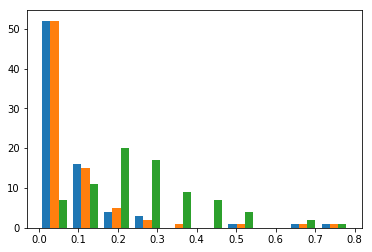

In [11]:
plt.hist((list(strictdf['head-@1']),list(strictdf['all-@1']),list(strictdf['head-l-@1'])))

([array([38., 12.,  8.,  3.,  4.,  8.,  1.,  2.,  2.,  0.]),
  array([31., 16.,  6.,  4.,  7.,  6.,  4.,  1.,  2.,  1.]),
  array([28., 16.,  6.,  6.,  4.,  3.,  8.,  3.,  2.,  2.]),
  array([22., 12., 10.,  9.,  2.,  2.,  7.,  7.,  4.,  3.])],
 array([0.        , 0.08672199, 0.17344398, 0.26016598, 0.34688797,
        0.43360996, 0.52033195, 0.60705394, 0.69377593, 0.78049793,
        0.86721992]),
 <a list of 4 Lists of Patches objects>)

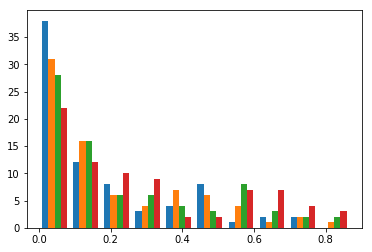

In [12]:
plt.hist((list(strictdf['head-@5']),list(strictdf['all-@5']),list(strictdf['head-@10']),list(strictdf['all-@10'])))

In [73]:
refdf.head()

,i_corpus,image_id,region_id,names,refexps,cat,ix_Xfile
0,1,581857,1719310,"[person, lady, shirt]","[the lady with the blue shirt, lady with back ...",1,34271
1,1,581857,463958,"[person, woman]","[woman in gray shirt facing camera on right, w...",1,34270
2,1,581839,495152,[person],[person standing u],1,34771
3,1,581839,485695,"[person, girl, lady, woman]","[lady sitting on right, right girl on floor, w...",1,34770
4,1,581789,453177,"[person, woman]","[woman, left person, woman under suitcase]",1,32032


In [20]:
p = "../wacexp/wac_with_reduced_cat_2.json"
with open(p,'r') as f:
    wac_refs = json.load(f)

In [21]:
wac_refs

{u'124698': [[u'bike', u'0.998872'],
  [u'girl', u'0.924391'],
  [u'boat', u'0.475911'],
  [u'motorcycle', u'0.076258'],
  [u'canopy', u'0.011204'],
  [u'vehicle', u'0.008173'],
  [u'ground', u'0.006132'],
  [u'piece', u'0.005791'],
  [u'thing', u'0.003983'],
  [u'crib', u'0.003543']],
 u'124725': [[u'cat', u'0.343765'],
  [u'orange', u'0.099268'],
  [u'bird', u'0.086158'],
  [u'motorcycle', u'0.051361'],
  [u'light', u'0.035449'],
  [u'truck', u'0.028653'],
  [u'pot', u'0.021497'],
  [u'kitty', u'0.021308'],
  [u'bike', u'0.018577'],
  [u'bucket', u'0.013215']],
 u'124935': [[u'bike', u'0.959810'],
  [u'person', u'0.094087'],
  [u'girl', u'0.093720'],
  [u'guy', u'0.089677'],
  [u'box', u'0.079244'],
  [u'luggage', u'0.038128'],
  [u'apron', u'0.036716'],
  [u'cup', u'0.032182'],
  [u'tray', u'0.024371'],
  [u'motorcycle', u'0.014665']],
 u'124951': [[u'cat', u'0.853432'],
  [u'orange', u'0.097446'],
  [u'reflection', u'0.038528'],
  [u'table', u'0.027690'],
  [u'slice', u'0.021809'],

In [24]:
def eval_wac_strict_at10(region2ref,refdf):
    acc_at_n = {1:0,5:0,10:0}
    total = 0

    for r in region2ref:
    #print r
        utt_names = region2ref[r]
        this_df = refdf[refdf.region_id == int(r)]
        if len(this_df) > 0:
            gold_names = this_df.iloc[0]['names']
            total += 1
            #print(utt_names)
            cand = [w for w,_ in utt_names]
            for ix in acc_at_n:
                if len(set(cand[:ix]) & set(gold_names)) > 0:
                    acc_at_n[ix] += 1                    
        else:
            continue
    for ix in acc_at_n:
        print(ix,float(acc_at_n[ix])/total)
    return acc_at_n,total

In [25]:
all_rows2 = []

for i in range(1,91):
    p = "../wacexp/wac_with_reduced_cat_%d.json"%(i)
    try:
        with open(p,'r') as f:
            wac_refs = json.load(f)
    except:
        print "No file for cat",i
        continue
    head_accs,t = eval_wac_strict_at10(wac_refs,refdf)
    row1 = [float(head_accs[ia])/float(t) for ia in sorted(head_accs.keys())]
    all_rows2.append([str(i),t]+row1)

(1, 0.010944910616563297)
(10, 0.21731728079776239)
(5, 0.1003283473184969)
(1, 0.30851063829787234)
(10, 0.8031914893617021)
(5, 0.7074468085106383)
(1, 0.08280254777070063)
(10, 0.695859872611465)
(5, 0.5445859872611465)
(1, 0.23783031988873435)
(10, 0.7496522948539638)
(5, 0.6258692628650904)
(1, 0.013953488372093023)
(10, 0.037209302325581395)
(5, 0.027906976744186046)
(1, 0.1264957264957265)
(10, 0.841025641025641)
(5, 0.6547008547008547)
(1, 0.1092896174863388)
(10, 0.644808743169399)
(5, 0.5245901639344263)
(1, 0.21978021978021978)
(10, 0.7538461538461538)
(5, 0.6417582417582418)
(1, 0.007177033492822967)
(10, 0.09090909090909091)
(5, 0.03349282296650718)
(1, 0.009174311926605505)
(10, 0.05504587155963303)
(5, 0.045871559633027525)
(1, 0.0)
(10, 0.0)
(5, 0.0)
No file for cat 12
(1, 0.16666666666666666)
(10, 0.6666666666666666)
(5, 0.5)
(1, 0.019801980198019802)
(10, 0.0297029702970297)
(5, 0.019801980198019802)
(1, 0.08823529411764706)
(10, 0.35294117647058826)
(5, 0.24019607843

In [54]:
wacdf = pd.DataFrame(all_rows2,columns=['cat','total','wac-head-@1','wac-head-@5','wac-head-@10'])

In [55]:
wacdf

,cat,total,wac-head-@1,wac-head-@5,wac-head-@10
0,1,24669,0.010945,0.100328,0.217317
1,2,188,0.308511,0.707447,0.803191
2,3,628,0.082803,0.544586,0.695860
3,4,719,0.237830,0.625869,0.749652
4,5,215,0.013953,0.027907,0.037209
5,6,585,0.126496,0.654701,0.841026
6,7,366,0.109290,0.524590,0.644809
7,8,455,0.219780,0.641758,0.753846
8,9,418,0.007177,0.033493,0.090909
9,10,109,0.009174,0.045872,0.055046


In [56]:
wacdf.describe()

,total,wac-head-@1,wac-head-@5,wac-head-@10
count,78.000000,78.000000,78.000000,78.000000
mean,639.294872,0.062202,0.238278,0.339414
std,2772.912127,0.073445,0.218270,0.260201
min,1.000000,0.000000,0.000000,0.000000
25%,57.500000,0.007547,0.052024,0.107906
50%,245.500000,0.036812,0.165917,0.311520
75%,538.500000,0.093558,0.422417,0.573043
max,24669.000000,0.352697,0.771784,0.850622


In [57]:
strictdf.describe()

,total,head-@1,head-@5,head-@10,head-l-@1,all-@1,all-@5,all-@10
count,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000
mean,639.294872,0.080852,0.175311,0.237682,0.259791,0.085854,0.204759,0.295804
std,2772.912127,0.133206,0.200439,0.239255,0.151022,0.134804,0.211868,0.257338
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,57.500000,0.000740,0.016398,0.037523,0.161797,0.004727,0.032096,0.077173
50%,245.500000,0.029065,0.087651,0.129099,0.237692,0.033385,0.127984,0.210977
75%,538.500000,0.095133,0.268883,0.405750,0.345634,0.104470,0.366940,0.539950
max,24669.000000,0.712766,0.765957,0.838174,0.787234,0.723404,0.808511,0.867220


In [70]:
print(len(strictdf),len(wacdf))

(78, 78)


In [74]:
bdf = pd.concat([wacdf[['total','cat','wac-head-@1']],strictdf[['cat','head-@1']]],axis=1)

In [175]:
bdf.sort_values(by=['head-@1'],ascending=False)

,total,cat,wac-head-@1,cat,head-@1
1,188,2,0.308511,2,0.712766
29,3,34,0.000000,34,0.666667
40,241,46,0.352697,46,0.514523
63,319,73,0.065831,73,0.310345
3,719,4,0.237830,4,0.285118
36,21,41,0.095238,41,0.238095
2,628,3,0.082803,3,0.229299
24,57,27,0.175439,27,0.228070
57,744,63,0.197581,63,0.212366
26,55,31,0.054545,31,0.181818


In [79]:
glove_heads.vocab

{u'adult': <gensim.models.keyedvectors.Vocab at 0x7f6a8e019fd0>,
 u'air': <gensim.models.keyedvectors.Vocab at 0x7f6a8e0261d0>,
 u'airplane': <gensim.models.keyedvectors.Vocab at 0x7f6a8dfb4a10>,
 u'ambulance': <gensim.models.keyedvectors.Vocab at 0x7f6a8dfb4d90>,
 u'animal': <gensim.models.keyedvectors.Vocab at 0x7f6a8dfc23d0>,
 u'animals': <gensim.models.keyedvectors.Vocab at 0x7f6a8ea68150>,
 u'apple': <gensim.models.keyedvectors.Vocab at 0x7f6a8e0113d0>,
 u'apples': <gensim.models.keyedvectors.Vocab at 0x7f6a8e0266d0>,
 u'appliance': <gensim.models.keyedvectors.Vocab at 0x7f6a8e02c0d0>,
 u'apron': <gensim.models.keyedvectors.Vocab at 0x7f6a8dfdd450>,
 u'area': <gensim.models.keyedvectors.Vocab at 0x7f6a8e011410>,
 u'arm': <gensim.models.keyedvectors.Vocab at 0x7f6a8dfd0510>,
 u'armchair': <gensim.models.keyedvectors.Vocab at 0x7f6a8e019f50>,
 u'arms': <gensim.models.keyedvectors.Vocab at 0x7f6a8e01fbd0>,
 u'army': <gensim.models.keyedvectors.Vocab at 0x7f6a8e0112d0>,
 u'art': <gens

In [81]:
cat_lines = open("../../data/cats.txt").readlines()

In [86]:
id2cat = dict([(line.split(' , ')[0],line.split(' , ')[1].strip()) for line in cat_lines])

In [124]:
id2wac = dict([tuple(x) for x in wacdf[['cat','wac-head-@1']].values])
cat2vec = {}
for catid in id2cat:
    if id2cat[catid] in glove_heads.vocab:
        #print(id2cat[catid])
        cat2vec[catid] = (id2cat[catid],glove_heads[id2cat[catid]],id2wac[catid])
   
        

In [198]:
def tsnescatterplot(word_vector_tup):
    arr = np.empty((0, 300), dtype='f')
    word_labels = []
    word_colors = []

    for (word,vec,acc) in word_vector_tup:
        arr = np.append(arr, vec.reshape((1,300)), axis = 0)
        word_labels.append(word)
        word_colors.append(acc)
        

    # find tsne coords for 2 dimensions
    pca = PCA(n_components=50)
    Y0 = pca.fit_transform(arr)
    
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(Y0)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    
    fig = plt.figure(figsize=(10,10))
    
    ax = fig.add_subplot(111)

    ax.scatter(x_coords, y_coords, c = word_colors, cmap=plt.cm.get_cmap('hot'),vmax=0.35)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        ax.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')

    #plt.xlim(x_coords.min() + 0.5, x_coords.max() + 0.5)
    #plt.ylim(y_coords.min() + 0.5, y_coords.max() + 0.5)
    plt.show()
    




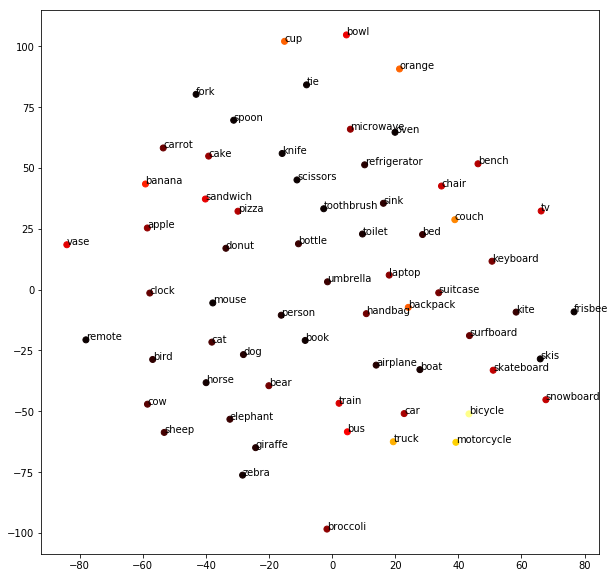

In [199]:
tsnescatterplot(cat2vec.values())

In [200]:
id2lstm = dict([tuple(x) for x in strictdf[['cat','head-@1']].values])
lstmcat2vec = {}
for catid in id2cat:
    if id2cat[catid] in glove_heads.vocab:
        #print(id2cat[catid])
        lstmcat2vec[catid] = (id2cat[catid],glove_heads[id2cat[catid]],id2lstm[catid])

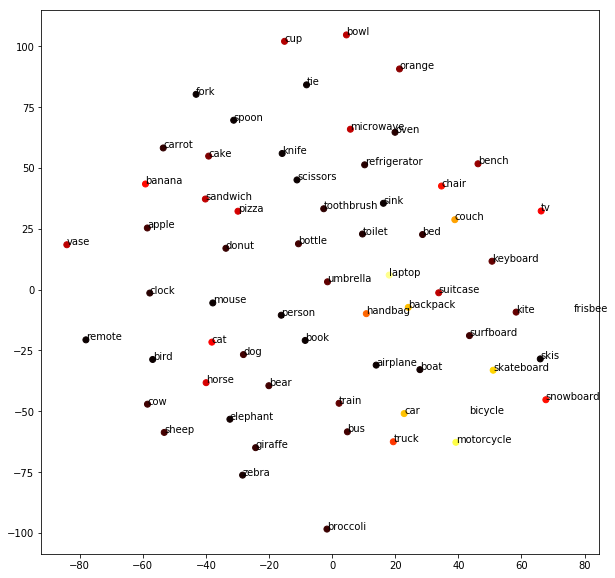

In [201]:
tsnescatterplot(lstmcat2vec.values())

In [105]:
cat2vec.values()[0][1].reshape((1,300))

array([[-0.36589  , -0.33645  , -0.029113 , -0.12239  , -0.20295  ,
        -0.11143  , -0.40893  ,  0.82255  , -0.31376  , -0.85765  ,
         0.082918 ,  0.56095  ,  0.073434 , -0.0023222,  0.42559  ,
        -0.045448 ,  0.063513 ,  0.65384  , -0.26128  ,  0.1132   ,
         0.3557   ,  0.26382  ,  0.35047  ,  0.18128  , -0.22542  ,
        -0.20177  , -0.30982  ,  0.047096 , -0.27765  ,  0.36989  ,
        -0.061411 , -0.30623  ,  0.19469  ,  0.31558  ,  0.157    ,
         0.1092   ,  0.42568  , -0.076906 , -0.20563  , -0.02083  ,
         0.19445  , -0.03529  ,  0.13524  , -0.071738 , -0.012366 ,
        -0.49091  , -0.10542  , -0.056016 , -0.22297  , -0.53185  ,
        -0.076094 ,  0.16089  ,  0.28351  ,  0.28491  , -0.15823  ,
        -0.15728  , -0.18432  ,  0.2838   ,  0.59147  ,  0.1082   ,
         0.3702   ,  0.28063  , -0.56152  ,  0.4356   , -0.23523  ,
         0.41738  , -0.46563  ,  0.43253  , -0.17113  ,  0.278    ,
        -0.45543  ,  0.017631 , -0.36731  , -0.3

In [ ]:
def display_closestwords_tsnescatterplot(model, word):
    arr = np.empty((0, 300), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word, 25)

    arr = np.append(arr, np.array([model[word]]), axis = 0)

    # add the vector for each of the closest words to the array
    for i, wrd_score in enumerate(close_words):
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis = 0)

    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]

    plt.scatter(x_coords, y_coords, c = "blue")

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')

    plt.xlim(x_coords.min() + 0.00005, x_coords.max() + 0.00005)
    plt.ylim(y_coords.min() + 0.00005, y_coords.max() + 0.00005)
    plt.show()


In [44]:
nocardf = refdf[refdf.cat != 3]

In [59]:
has_car = nocardf.refexps.apply(lambda x: "car" in " ".join(x).split())

In [60]:
nocardf[has_car]

,i_corpus,image_id,region_id,names,refexps,cat,ix_Xfile
719,1,573807,1367424,"[car, truck]","[red car front, red car, red truck]",8,326
1601,1,564063,396717,"[car, truck, vehicle]","[truck closest to us, front car, closest vehicle]",8,28780
2097,1,558817,1089473,"[section, car, cake]","[blue car, blue cake in center, blue section]",61,46384
2275,1,556399,2111066,"[object, car, banana, item]","[item on right, right top object, car on right...",52,46808
2290,1,556154,1198159,"[car, truck, vehicle, mirror]","[the white vanin the mirror, white vehicle in ...",8,13588
2455,1,554015,2050788,"[one, train]","[red train car, red caboose please get this on...",7,16397
2679,1,551542,419514,"[car, meter]","[right parking meter, car meter to the right]",14,29516
4834,1,526514,1372958,"[car, truck, van]","[car on the far left with little yellow light,...",8,13059
5055,1,523564,1799607,"[car, truck]","[car by hydrant, car beside hydrant]",8,834
5601,1,517603,1368300,"[van, truck, car]","[white van on left, white car on left, white v...",8,5284


In [48]:
nocar_vocab = Counter(" ".join([ref for reflist in list(nocardf.refexps) for ref in reflist]).split())

In [51]:
nocar_vocab['car']

196

In [52]:
nocar_vocab['vehicle']

87

In [53]:
nocar_vocab['van']

67

In [54]:
nocar_vocab['taxi']

7

In [55]:
noboatdf = refdf[refdf.cat != 9]

In [56]:
noboat_vocab = Counter(" ".join([ref for reflist in list(noboatdf.refexps) for ref in reflist]).split())

In [58]:
noboat_vocab['ship']

4

In [14]:
127.0/628.0

0.20222929936305734

In [15]:
'car' in glove_heads

True

In [5]:
p = "/media/compute/vol/dsg/lilian/exp/with_reduced_cats_6/all_highest_probs_10.json"
with open(p,'r') as f:
    bus_refs = json.load(f)

In [6]:
bus_refs

{u'1195945': {u'1': [[u'train', u'0.016573511'],
   [u'the', u'0.018637383'],
   [u'far', u'0.023163501'],
   [u'white', u'0.023252565'],
   [u'UNKNOWN', u'0.023332795'],
   [u'green', u'0.027130112'],
   [u'silver', u'0.027434634'],
   [u'red', u'0.08854575'],
   [u'blue', u'0.17051491'],
   [u'right', u'0.4083742']],
  u'2': [[u'train', u'0.037200544'],
   [u'red', u'0.038436975'],
   [u'UNKNOWN', u'0.03946866'],
   [u'vehicle', u'0.050967593'],
   [u'blue', u'0.05498355'],
   [u'car', u'0.055575587'],
   [u'EDGE', u'0.06597308'],
   [u'truck', u'0.071919344'],
   [u'most', u'0.07340572'],
   [u'side', u'0.17620191']],
  u'3': [[u'white', u'0.016033934'],
   [u'car', u'0.019910634'],
   [u'yellow', u'0.021203695'],
   [u'green', u'0.021513676'],
   [u'silver', u'0.038491096'],
   [u'UNKNOWN', u'0.050973233'],
   [u'red', u'0.064618945'],
   [u'blue', u'0.071103774'],
   [u'EDGE', u'0.0947339'],
   [u'of', u'0.3757237']],
  u'4': [[u'photo', u'0.02591664'],
   [u'picture', u'0.0283614

In [7]:
for i in range(1,81):
    p = "/media/compute/vol/dsg/lilian/exp/with_reduced_cats_%d/refs_moved_to_test.json"%i
    try:
        with open(p,'r') as f:
            refs = json.load(f)
    except:
        print "no cat",i
    print i, len(refs)

1 24669
2 188
3 628
4 719
5 215
6 585
7 366
8 455
9 418
10 109
11 13
no cat 12
12 13
13 6
14 101
15 204
16 257
17 391
18 344
19 751
20 705
21 743
22 1062
23 203
24 1053
25 1010
no cat 26
26 1010
27 57
28 399
no cat 29
29 399
no cat 30
30 399
31 55
32 59
33 594
34 3
35 12
36 52
37 2
38 84
39 5
40 2
41 21
42 146
43 15
44 276
no cat 45
45 276
46 241
47 478
48 1
49 13
50 15
51 997
52 577
53 322
54 791
55 439
56 504
57 138
58 226
59 836
60 765
61 541
62 1024
63 744
64 250
65 336
no cat 66
66 336
67 531
no cat 68
68 531
no cat 69
69 531
70 231
no cat 71
71 231
72 374
73 319
74 10
75 94
76 86
77 109
78 42
79 125
80 0


In [5]:
len(refs)

24669

In [8]:
p = "/media/compute/vol/dsg/lilian/exp/with_reduced_cats_%d/index2token.json"%1
try:
    with open(p,'r') as f:
        index = json.load(f)
except:
    print "no cat",i


In [9]:
index

{u'344': u'guys',
 u'345': u'bunk',
 u'346': u'frt',
 u'347': u'brush',
 u'340': u'leg',
 u'341': u'clear',
 u'342': u'partially',
 u'343': u'bun',
 u'348': u'closet',
 u'349': u'mans',
 u'1653': u'c',
 u'298': u'are',
 u'299': u'blk',
 u'296': u'salad',
 u'297': u'space',
 u'294': u'his',
 u'295': u'lady',
 u'292': u'away',
 u'293': u'group',
 u'290': u'tallest',
 u'291': u'tire',
 u'270': u'brocoli',
 u'271': u'stuffed',
 u'272': u'duck',
 u'273': u'boy',
 u'274': u'over',
 u'275': u'sauce',
 u'276': u'view',
 u'277': u'lol',
 u'278': u'rice',
 u'279': u'shelf',
 u'1780': u'icecream',
 u'1781': u'ignore',
 u'108': u'dark',
 u'109': u'toilet',
 u'102': u'a',
 u'103': u'plane',
 u'100': u'board',
 u'101': u'small',
 u'106': u'under',
 u'107': u'facing',
 u'104': u'bottle',
 u'105': u'light',
 u'1372': u'yay',
 u'1001': u'piza',
 u'1210': u'wheeler',
 u'1375': u'15',
 u'1655': u'cactus',
 u'1374': u'13',
 u'99': u'not',
 u'98': u'next',
 u'91': u'book',
 u'90': u'bench',
 u'93': u'above

In [10]:
p = "/media/compute/vol/dsg/lilian/exp/with_reduced_cats_1/inject_refcoco_refrnn_compositional_3_512_1/4eval_greedy.json"
with open(p,'r') as f:
    evalf = json.load(f)

In [11]:
evalf

{u'228051': [u'right chair'],
 u'1307837': [u'red umbrella'],
 u'460069': [u'chair behind kid'],
 u'460063': [u'green chair'],
 u'460061': [u'right snowboard'],
 u'1246688': [u'UNKNOWN'],
 u'1246689': [u'black bag on right'],
 u'256900': [u'horse on the left'],
 u'2198345': [u'black thing on right'],
 u'1723334': [u'black bag on right'],
 u'1751012': [u'blurry blurry blurry blurry blurry blurry blurry blurry blurry back left'],
 u'1751010': [u'left side of the chair'],
 u'1271606': [u'horse on the right'],
 u'1271604': [u'horse on the right'],
 u'214070': [u'horse on the right'],
 u'1271603': [u'horse on the right'],
 u'452894': [u'black thing on right'],
 u'1755772': [u'chair on the right'],
 u'1245131': [u'car on the left'],
 u'498604': [u'left of horse'],
 u'493650': [u'chair on the right'],
 u'1246532': [u'table behind woman'],
 u'1273116': [u'left chair'],
 u'458335': [u'the chair behind the woman'],
 u'523053': [u'right horse'],
 u'489165': [u'left car'],
 u'494922': [u'horse on 